<a href="https://colab.research.google.com/github/Roy-Subhankar/SGEMM-GPU-Kernel-Performance/blob/main/Subhankar_Roy_SGEMM_GPU_Kernel_Performance_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Predicting the running times for multiplying two 2048 x 2048 matrices using a GPU OpenCL SGEMM kernel with varying parameters (using the library 'CLTune'). </u></b>

## <b> Problem Description </b>

### This data set measures the running time of a matrix-matrix product $A*B = C$, where all matrices have size 2048 x 2048, using a parameterizable SGEMM GPU kernel with 241600 possible parameter combinations. For each tested combination, 4 runs were performed and their results are reported as the 4 last columns. All times are measured in milliseconds*.

### There are 14 parameter, the first 10 are ordinal and can only take up to 4 different powers of two values, and the 4 last variables are binary. Out of 1327104 total parameter combinations, only 241600 are feasible (due to various kernel constraints). This data set contains the results for all these feasible combinations.

### The experiment was run on a desktop workstation running Ubuntu 16.04 Linux with an Intel Core i5 (3.5GHz), 16GB RAM, and a NVidia Geforce GTX 680 4GB GF580 GTX-1.5GB GPU. We use the 'gemm_fast' kernel from the automatic OpenCL kernel tuning library 'CLTune' ([Web Link]).

#### * Note: for this kind of data sets it is usually better to work with the logarithm of the running times 


## <b> Data Description </b>

### <b>Attribute Information: </b>

### Independent variables:
* ### MWG, NWG: per-matrix 2D tiling at workgroup level: {16, 32, 64, 128} (integer)
* ### KWG: inner dimension of 2D tiling at workgroup level: {16, 32} (integer)
* ### MDIMC, NDIMC: local workgroup size: {8, 16, 32} (integer)
* ### MDIMA, NDIMB: local memory shape: {8, 16, 32} (integer)
* ### KWI: kernel loop unrolling factor: {2, 8} (integer)
* ### VWM, VWN: per-matrix vector widths for loading and storing: {1, 2, 4, 8} (integer)
* ### STRM, STRN: enable stride for accessing off-chip memory within a single thread: {0, 1} (categorical)
* ### SA, SB: per-matrix manual caching of the 2D workgroup tile: {0, 1} (categorical)

### Output:
* ### Run1, Run2, Run3, Run4: performance times in milliseconds for 4 independent runs using the same parameters. They range between 13.25 and 3397.08.

In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import time
import warnings
warnings.simplefilter("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the dataset
dataset=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Supervised ML - Regression Project/sgemm_product.csv')

In [ ]:
# View the dataset
dataset.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81


In [ ]:
dataset.tail()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
241595,128,128,32,32,32,32,32,8,4,4,1,0,1,1,17.96,17.77,17.77,17.77
241596,128,128,32,32,32,32,32,8,4,4,1,1,0,0,36.04,36.03,36.04,36.03
241597,128,128,32,32,32,32,32,8,4,4,1,1,0,1,35.28,34.82,35.27,35.27
241598,128,128,32,32,32,32,32,8,4,4,1,1,1,0,28.43,28.49,28.44,28.45
241599,128,128,32,32,32,32,32,8,4,4,1,1,1,1,17.94,17.79,17.77,17.77


In [ ]:
dataset.columns

Index(['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM',
       'VWN', 'STRM', 'STRN', 'SA', 'SB', 'Run1 (ms)', 'Run2 (ms)',
       'Run3 (ms)', 'Run4 (ms)'],
      dtype='object')

We have four different run time in our dependent variable. we have to convert this four runtime into a single runtime.

In [ ]:
# Get average runtime
dataset['avg_runtime']=(dataset['Run1 (ms)']+dataset['Run2 (ms)']+dataset['Run3 (ms)']+dataset['Run4 (ms)'])/4
# Drop the individual runtime
dataset.drop(['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)'],axis=1,inplace=True)

In [ ]:
# View the dataset
dataset.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,avg_runtime
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,116.3700
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.7050
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,80.5650
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,86.6375
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,118.6625


In [ ]:
dataset.tail()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,avg_runtime
241595,128,128,32,32,32,32,32,8,4,4,1,0,1,1,17.8175
241596,128,128,32,32,32,32,32,8,4,4,1,1,0,0,36.0350
241597,128,128,32,32,32,32,32,8,4,4,1,1,0,1,35.1600
241598,128,128,32,32,32,32,32,8,4,4,1,1,1,0,28.4525
241599,128,128,32,32,32,32,32,8,4,4,1,1,1,1,17.8175


In [ ]:
dataset.columns

Index(['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM',
       'VWN', 'STRM', 'STRN', 'SA', 'SB', 'avg_runtime'],
      dtype='object')

In [ ]:
# Describe the features
dataset.describe()


,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,avg_runtime
count,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000
mean,80.415364,80.415364,25.513113,13.935894,13.935894,17.371126,17.371126,5.000000,2.448609,2.448609,0.500000,0.500000,0.500000,0.500000,217.571953
std,42.469220,42.469220,7.855619,7.873662,7.873662,9.389418,9.389418,3.000006,1.953759,1.953759,0.500001,0.500001,0.500001,0.500001,368.750161
min,16.000000,16.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.317500
25%,32.000000,32.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,40.667500
50%,64.000000,64.000000,32.000000,8.000000,8.000000,16.000000,16.000000,5.000000,2.000000,2.000000,0.500000,0.500000,0.500000,0.500000,69.790000
75%,128.000000,128.000000,32.000000,16.000000,16.000000,32.000000,32.000000,8.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,228.387500
max,128.000000,128.000000,32.000000,32.000000,32.000000,32.000000,32.000000,8.000000,8.000000,8.000000,1.000000,1.000000,1.000000,1.000000,3341.507500


In [ ]:
# Check dataset info
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241600 entries, 0 to 241599
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   MWG          241600 non-null  int64  
 1   NWG          241600 non-null  int64  
 2   KWG          241600 non-null  int64  
 3   MDIMC        241600 non-null  int64  
 4   NDIMC        241600 non-null  int64  
 5   MDIMA        241600 non-null  int64  
 6   NDIMB        241600 non-null  int64  
 7   KWI          241600 non-null  int64  
 8   VWM          241600 non-null  int64  
 9   VWN          241600 non-null  int64  
 10  STRM         241600 non-null  int64  
 11  STRN         241600 non-null  int64  
 12  SA           241600 non-null  int64  
 13  SB           241600 non-null  int64  
 14  avg_runtime  241600 non-null  float64
dtypes: float64(1), int64(14)
memory usage: 27.6 MB


In [ ]:
#Checking unique values
dataset.nunique()

MWG                 4
NWG                 4
KWG                 2
MDIMC               3
NDIMC               3
MDIMA               3
NDIMB               3
KWI                 2
VWM                 4
VWN                 4
STRM                2
STRN                2
SA                  2
SB                  2
avg_runtime    131488
dtype: int64

In [ ]:
#Checking missing values
dataset.isnull().sum()

MWG            0
NWG            0
KWG            0
MDIMC          0
NDIMC          0
MDIMA          0
NDIMB          0
KWI            0
VWM            0
VWN            0
STRM           0
STRN           0
SA             0
SB             0
avg_runtime    0
dtype: int64

we see that there is a large variation in the 'avg_runtime' feature and avg_runtime mean(217.57) >> median(69.79), that means our terget variable is positively skewed.

###let's see this graphically

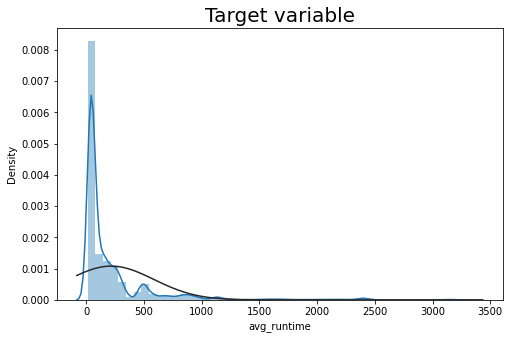

In [ ]:
plt.figure(figsize=(8,5))
sns.distplot(dataset['avg_runtime'], fit=norm)
plt.title('Target variable',fontsize=20)
plt.show()

so the dependent variable is positively skewed.

###Feature transformation

In [ ]:
# To cancle this skewness we use log transformation
dataset['log_avg_runtime']=np.log10(dataset['avg_runtime'])
# drop the avg_runtime
# dataset.drop(['avg_runtime'],axis=1,inplace=True)

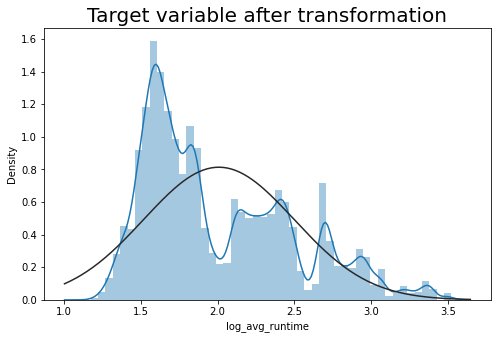

In [ ]:
#let's see this graphically
plt.figure(figsize=(8,5))
sns.distplot(dataset['log_avg_runtime'], fit=norm)
plt.title('Target variable after transformation',fontsize=20)
plt.show()

In [ ]:
indep_variable=dataset.drop(['avg_runtime','log_avg_runtime'],axis=1)
target_variable=dataset['log_avg_runtime']

In [ ]:
# for col in indep_variable.describe().columns:
#   dataset.groupby(indep_variable[col])['avg_runtime'].mean().plot(kind='bar')
#   plt.title(f'relation b/w {col} and avg_runtime')
#   plt.xlabel(col)
#   plt.show()

In [ ]:
#Capping the outlier rows with Percentiles
# for col in indep_variable.columns:
#   upper_lim = indep_variable[col].quantile(.95)
#   lower_lim = indep_variable[col].quantile(.05)
#   indep_variable.loc[(indep_variable[col] > upper_lim),col] = upper_lim
#   indep_variable.loc[(indep_variable[col] < lower_lim),col] = lower_lim

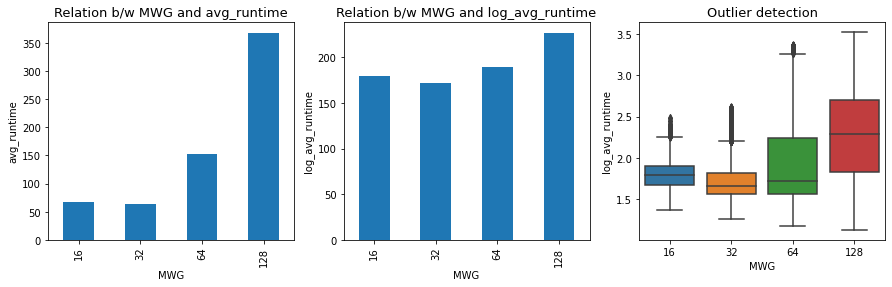

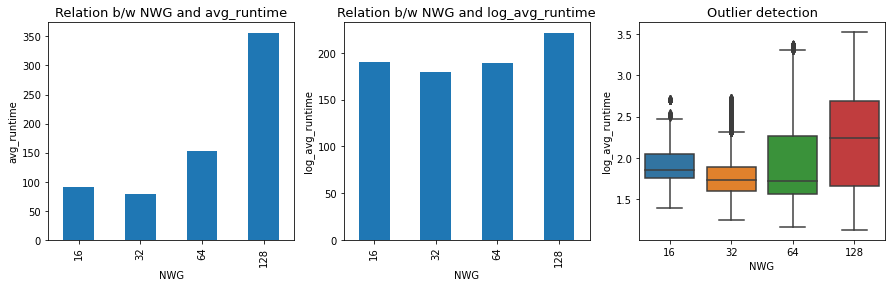

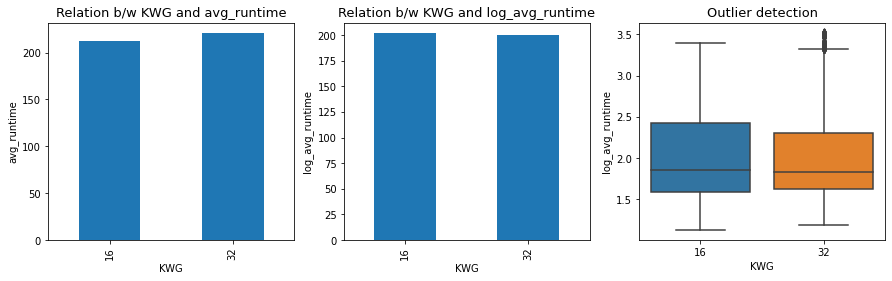

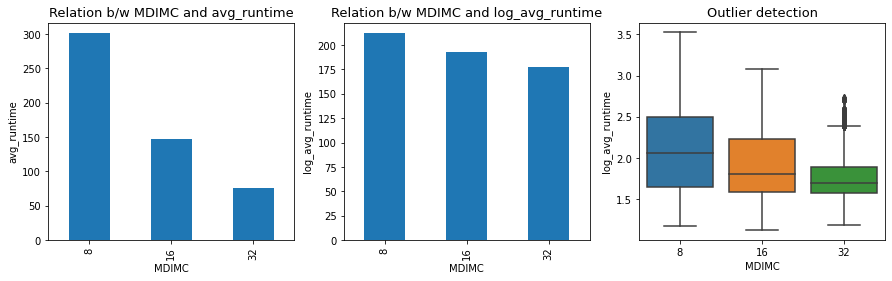

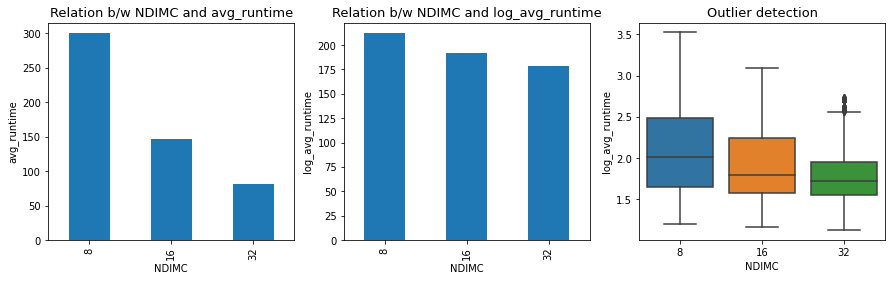

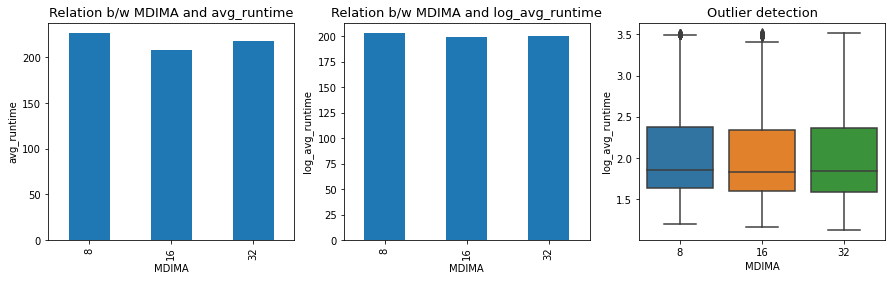

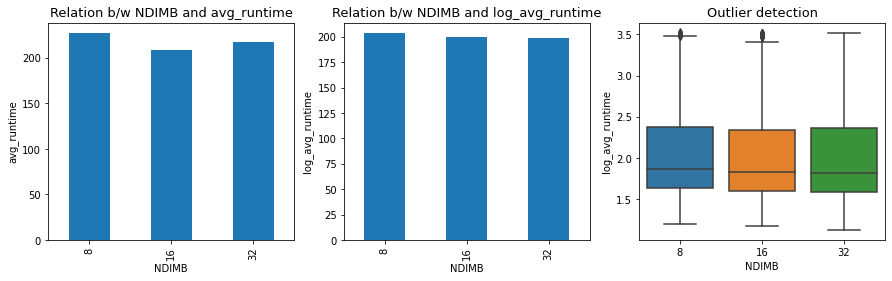

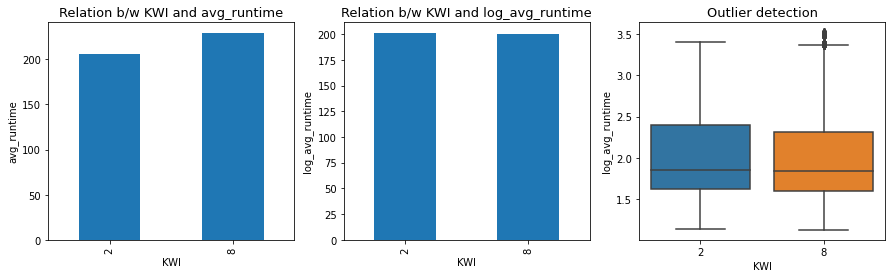

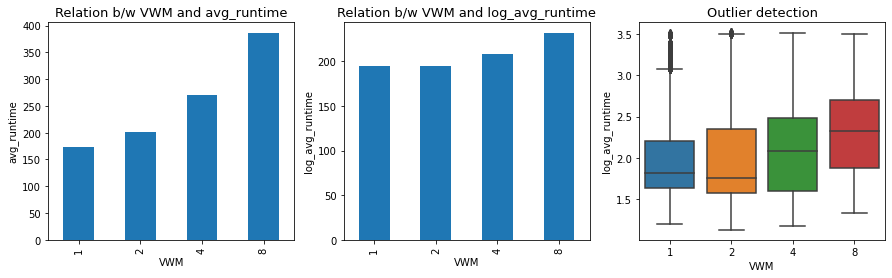

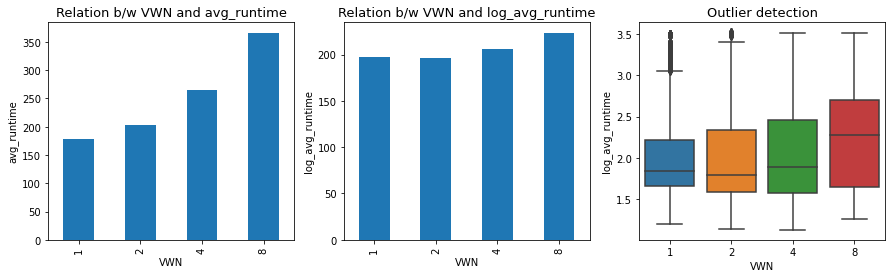

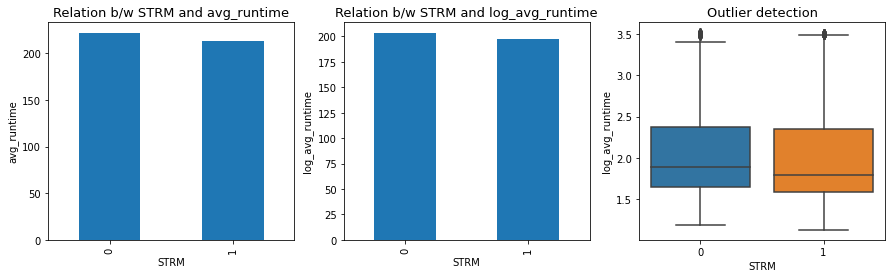

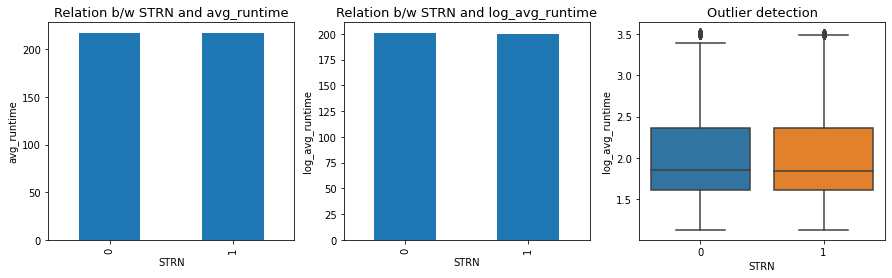

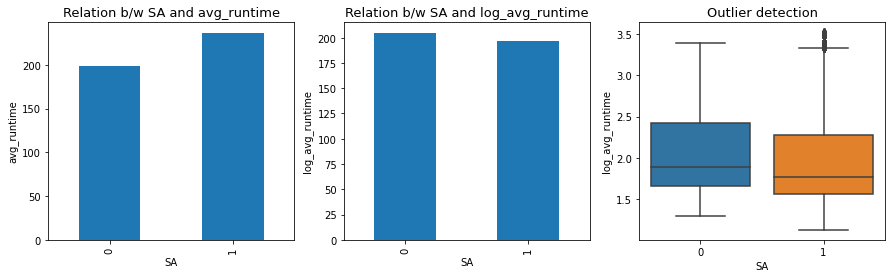

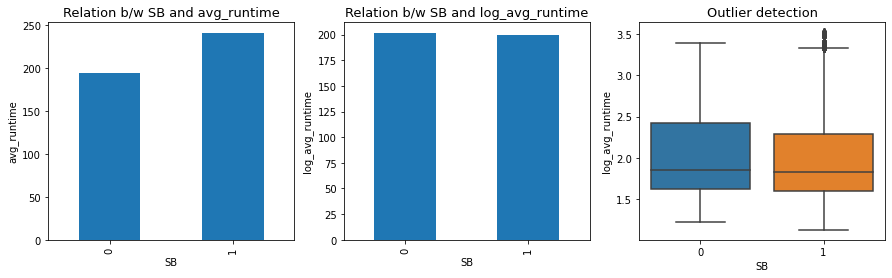

In [ ]:
for col in indep_variable.columns:
  plt.figure(figsize=(15,4))
  plt.subplot(1,3,1)
  dataset.groupby(indep_variable[col])['avg_runtime'].mean().plot(kind='bar')
  plt.title(f'Relation b/w {col} and avg_runtime',fontsize=13)
  plt.xlabel(col)
  plt.ylabel('avg_runtime')

  plt.subplot(1,3,2)
  dataset.groupby(indep_variable[col])['log_avg_runtime'].mean().mul(100).plot(kind='bar')
  plt.title(f'Relation b/w {col} and log_avg_runtime',fontsize=13)
  plt.xlabel(col)
  plt.ylabel('log_avg_runtime')
  

  plt.subplot(1,3,3)
  sns.boxplot(indep_variable[col],target_variable)
  plt.title('Outlier detection',fontsize=13)
  plt.xlabel(col)
  plt.show()

In [ ]:
# def outlier_treatment(df,feature):
#   upper_boundary= df[feature].mean()+3*df[feature].std()
#   lower_boundary= df[feature].mean()-3*df[feature].std()


In [ ]:
# outlier_treatment(indep_variable,target_variable)

In [ ]:
#drop the avg_runtime
dataset.drop(['avg_runtime'],axis=1,inplace=True)

###Check the correlation

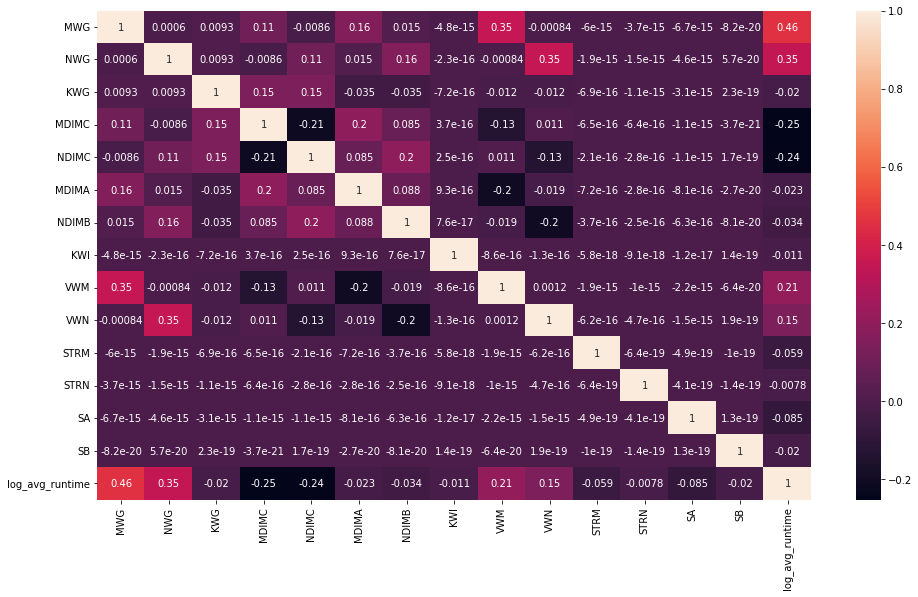

In [ ]:
plt.figure(figsize=(16,9))
sns.heatmap(dataset.corr(), annot=True)
plt.show()

###multicolinearity check

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame() # create a DataFrame where we will add feature and its respective vif value
    vif["variables"] = X.columns # Variable feature in vif dataframe will have columns from X i.e. input
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])] # vif value for that column 
    return(vif)

In [ ]:
calc_vif(dataset[[i for i in indep_variable.columns]])

,variables,VIF
0,MWG,5.570888
1,NWG,5.570888
2,KWG,9.434536
3,MDIMC,4.761904
4,NDIMC,4.761904
5,MDIMA,4.822777
6,NDIMB,4.822777
7,KWI,3.479154
8,VWM,3.097287
9,VWN,3.097287


In [ ]:
indep_variable.duplicated().sum()

0

###Split the dataset into Training and Testing

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(indep_variable,target_variable,test_size = 0.25, random_state=42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)


(181200, 14) (181200,)
(60400, 14) (60400,)


##LinearRegression Model


In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.5619526324105087

In [ ]:
reg.intercept_

1.8394936024374764

In [ ]:
reg.coef_

array([ 5.80226523e-03,  4.58473289e-03,  5.38247950e-03, -2.46928671e-02,
       -2.38193411e-02,  5.98169461e-05, -7.91400967e-05, -1.85119340e-03,
       -3.73443204e-03, -1.02799241e-02, -5.75000294e-02, -7.70047235e-03,
       -8.25263701e-02, -2.01815125e-02])

In [ ]:
y_pred = reg.predict(X_test)
y_train_pred = reg.predict(X_train)

###Model performance

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

MSE  = mean_squared_error(10**(y_test), 10**(y_pred))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(10**(y_test), 10**(y_pred))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score(10**(y_test), 10**(y_pred)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 84535.94399600205
RMSE : 290.7506560542935
R2 : 0.37676705067737615
Adjusted R2 :  0.3766225568247552


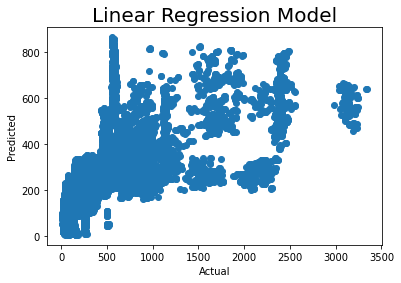

In [ ]:
plt.scatter(np.array(10**(y_test)),10**(y_pred))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear Regression Model',fontsize=20)
plt.show()

##Lasso regression with GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso


lasso = Lasso()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100,0.0014]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100, 0.0014]},
             scoring='neg_mean_squared_error')

In [ ]:
print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)
print("\nUsing ",lasso_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1e-05}

Using  {'alpha': 1e-05}  the negative mean squared error is:  -0.10543246700111779


In [ ]:
y_pred_lasso = lasso_regressor.predict(X_test)

###Model performance

In [ ]:
MSE  = mean_squared_error(10**(y_test), 10**(y_pred_lasso))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(10**(y_test), 10**(y_pred_lasso))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score(10**(y_test), 10**(y_pred_lasso)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 84534.08471116047
RMSE : 290.74745864953053
R2 : 0.3767807580723691
Adjusted R2 :  0.37663626739774814


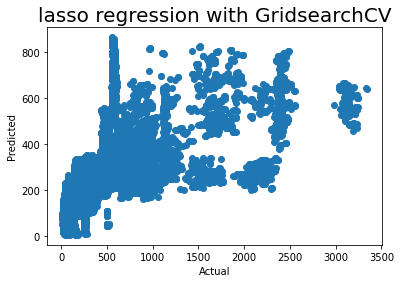

In [ ]:
plt.scatter(np.array(10**(y_test)),10**(y_pred_lasso))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('lasso regression with GridsearchCV',fontsize=20)
plt.show()

##XGBoost Regressor

In [ ]:
# Import the XGBRegressor algorithm
from sklearn import ensemble
from xgboost import XGBRegressor

In [ ]:
# capturing time before the multiplication of Python lists 

initialTime = time.time()

In [ ]:
# Try the different parameters, fixing min_samples_split = 30 
xgb =  XGBRegressor (n_estimators= 100,max_depth= 20, min_samples_split= 30, learning_rate= 0.1, loss= 'neg_mean_squared_error') #Got the parameter by hit and run method


In [ ]:
# Train the model
xgb.fit(X_train,y_train)
# Get Train score
xgb.score(X_train, y_train)

[17:02:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.999992513707325

In [ ]:
y_pred_xgb=xgb.predict(X_test)
y_train_pred = xgb.predict(X_train)
# get the test score
xgb.score(X_test, y_test)

0.9994601164278355

In [ ]:
# calculating execution time 
print("xgboost Execution time to train the data:",  
      (time.time() - initialTime), 
      "seconds")

xgboost Execution time to train the data: 129.84130239486694 seconds


###Model performance

In [ ]:
# Check the performance of the model using various metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

MSE  = mean_squared_error(10**(y_test), 10**(y_pred_xgb))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(10**(y_test), 10**(y_pred_xgb))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score(10**(y_test), 10**(y_pred_xgb)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 23.82693538575272
RMSE : 4.881284194323531
R2 : 0.9998243382576472
Adjusted R2 :  0.9998242975312351


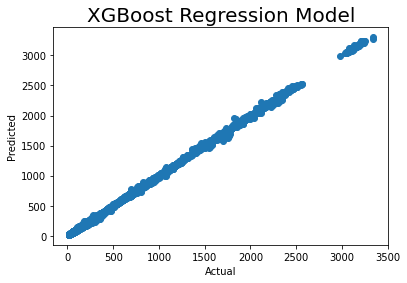

In [ ]:
plt.scatter(10**y_test, np.array(10**y_pred_xgb))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('XGBoost Regression Model',fontsize=20)
plt.show()

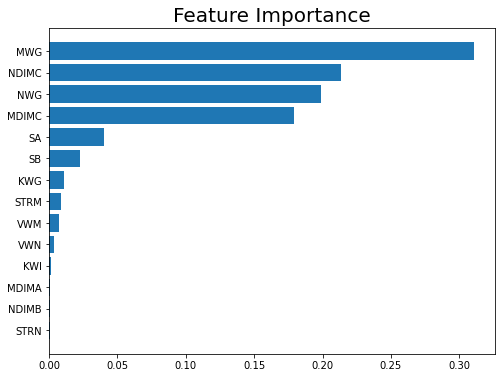

In [ ]:
features = indep_variable.columns
importances = xgb.feature_importances_
sort = np.argsort(importances)
plt.figure(figsize=(8,6))
plt.barh(range(len(sort)), importances[sort])
plt.yticks(range(len(sort)), [features[i] for i in sort])
plt.title('Feature Importance',fontsize=20)
plt.show()


In [ ]:
!pip install eli5

In [ ]:
import eli5 as eli
eli.explain_weights(xgb) # Get feature weights using eli5

Weight,Feature
0.3108,MWG
0.2136,NDIMC
0.1992,NWG
0.1793,MDIMC
0.0405,SA
0.0226,SB
0.0107,KWG
0.0089,STRM
0.0072,VWM
0.0036,VWN


This model performance is very good but the computation time is very long

let's find another model to save time

##Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()

In [ ]:
# capturing time before the multiplication of Python lists 
initialTime = time.time()

In [ ]:
tree.fit(X_train,y_train)
# Get Train score
tree.score(X_train, y_train)

1.0

In [ ]:
y_pred_tree=tree.predict(X_test)
# get the test score
tree.score(X_test, y_test)

0.9990477061579023

In [ ]:
# calculating execution time 
print("Decision Tree Execution time to train the data:",  
      (time.time() - initialTime), 
      "seconds")

Decision Tree Execution time to train the data: 1.8237969875335693 seconds


###Model performance

In [ ]:
MSE  = mean_squared_error(10**(y_test), 10**(y_pred_tree))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(10**(y_test), 10**(y_pred_tree))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score(10**(y_test), 10**(y_pred_tree)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 21.49514725310433
RMSE : 4.636285933061542
R2 : 0.9998415291367739
Adjusted R2 :  0.9998414923959925


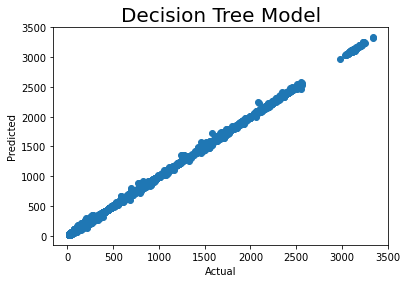

In [ ]:
plt.scatter(10**y_test, np.array(10**y_pred_tree))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Decision Tree Model',fontsize=20)
plt.show()

In [ ]:
tree.feature_importances_

array([0.28656889, 0.23532742, 0.01369399, 0.16906486, 0.20644838,
       0.00116676, 0.00114526, 0.00395974, 0.01431225, 0.00786454,
       0.01244867, 0.00138757, 0.02851634, 0.01809534])

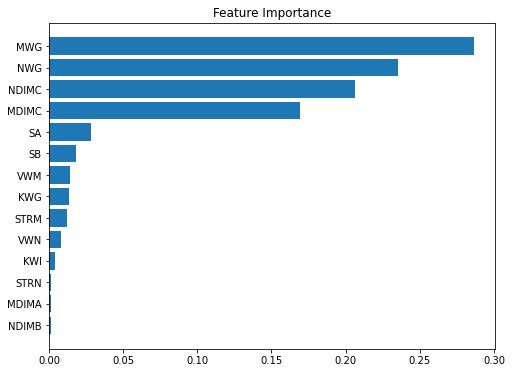

In [ ]:
features = indep_variable.columns
importances = tree.feature_importances_
sort = np.argsort(importances)
plt.figure(figsize=(8,6))
plt.barh(range(len(sort)), importances[sort])
plt.yticks(range(len(sort)), [features[i] for i in sort])
plt.title('Feature Importance',fontsize=20)
plt.show()

##Model Comparison based on performance

In [ ]:
# Get the model performance comparison table
def models_comparison(model_list,model_name_list,X_train,X_test,y_train,y_test):


  # Initialize the variables
  mse, rmse, r2, adj_r2 = [],[],[],[]
  for model_name in model_list:
    # Get the predicted classes
    train_class_preds = model_name.predict(X_train)
    test_class_preds = model_name.predict(X_test)

    # Get test scores
    mse.append(round(mean_squared_error(10**(y_test), 10**(test_class_preds)),2))
    rmse.append(round(np.sqrt(mean_squared_error(10**(y_test), 10**(test_class_preds))),2))
    r2.append(round(r2_score(10**y_test, 10**test_class_preds),4))
    adj_r2.append((round(1-(1-r2_score(10**(y_test), 10**(test_class_preds)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)),4)))

  # Prepare a metric dataframe
  model_comparison = pd.DataFrame(list(zip(model_name_list, mse, rmse, r2, adj_r2 )), columns = ['Model_Name','Mean Squared Error','Root Mean Squared error','R_square','Adj R_square'])
  return model_comparison 

In [ ]:
model_list = [reg,lasso_regressor,xgb,tree]
model_name_list = ['Linear regression model','Lasso with GridSearchCV','XGBoost model', 'Decision Tree model']

In [ ]:
# Call the function to get the comparison table
models_comparison(model_list, model_name_list, X_train, X_test, y_train, y_test)

,Model_Name,Mean Squared Error,Root Mean Squared error,R_square,Adj R_square
0,Linear regression model,84535.94,290.75,0.3768,0.3766
1,Lasso with GridSearchCV,84534.08,290.75,0.3768,0.3766
2,XGBoost model,23.83,4.88,0.9998,0.9998
3,Decision Tree model,21.50,4.64,0.9998,0.9998
